# Bank Classification Project

I will structure my project around [Jeff Leek's data analysis checklist](https://leanpub.com/datastyle).

## The Problem Domain

**Briar's Community Bank** - We are having a campaign. We want people to subscribe to a term deposit. We have been recording our success rate on clients for a while. Can you tell us who we can convert based on their financial data?

We have their age, job, employees, their loans, if they have any credit defaults, when we called them, their education, etc., and we also recorded if our call was successful or not. What can we learn? What would be useful for us?

## Answering the Question

*Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?*

We are trying to classify clients who will subscribe to a term deposit based on several demographic and financial metrics.

*Did you define the metric for success before beginning?*
  
Since we are performing classification, we can use accuracy - the fraction of correctly classified clients - to quantify how well our model is performing. Our head of data has told us that we should achieve at least 90% accuracy.
  
*Did you understand the context for the question and the scientific or business application?*

We are building part of a data analysis pipeline that will be able to classify the client's propensity for term deposits from his/her data on file with the bank. In the future, this pipeline will be connection to another pipeline that automatically generates customized marketing material for clients to be used in digital and print channels.

*Did you record the experimental design?*

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

*Did you consider whether the question could be answered with the available data?*

The data set we currently have is specifically tailored to term deposits. There is additional information about other financial products like a housing loan or personal load, but it would hard to generalize the model to all the other personal financial products offered through a community bank.

In [11]:
# Imports
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Checking the Data

In [8]:
bank_data = pd.read_csv('data/bank-additional/bank-additional-full.csv', 
                        sep=';', na_values=['NA'])

In [9]:
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [10]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [13]:
bank_data.job.nunique()

12

In [14]:
bank_data.job.value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [15]:
older = bank_data[bank_data.age > 60]

In [17]:
older.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 910 entries, 8645 to 41187
Data columns (total 21 columns):
age               910 non-null int64
job               910 non-null object
marital           910 non-null object
education         910 non-null object
default           910 non-null object
housing           910 non-null object
loan              910 non-null object
contact           910 non-null object
month             910 non-null object
day_of_week       910 non-null object
duration          910 non-null int64
campaign          910 non-null int64
pdays             910 non-null int64
previous          910 non-null int64
poutcome          910 non-null object
emp.var.rate      910 non-null float64
cons.price.idx    910 non-null float64
cons.conf.idx     910 non-null float64
euribor3m         910 non-null float64
nr.employed       910 non-null float64
y                 910 non-null object
dtypes: float64(5), int64(5), object(11)
memory usage: 156.4+ KB


There are several interesting categorical and numerical features. I will need to do more industry research to decide which to filter and which to perform one-hot encoding on. This may lead to a high-dimensional sparse data set. 

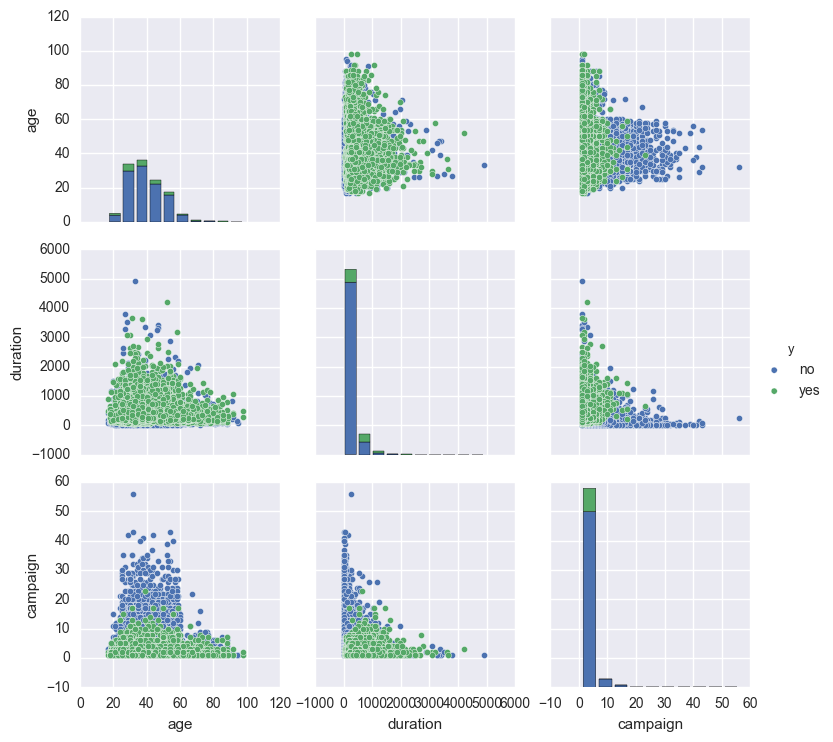

In [114]:
sns.pairplot(bank_data[['age', 'duration', 'campaign', 'y']].dropna(), hue='y')

Simple findings
- Number of previous contacts prior to campaign does not seem to affect yes / no
- Age does not seem to play a significant factor
- Larger number of contacts in a campaign is associated with more no
- The data is fairly clean with proper class labels and few missing values (this was used in graduate research)

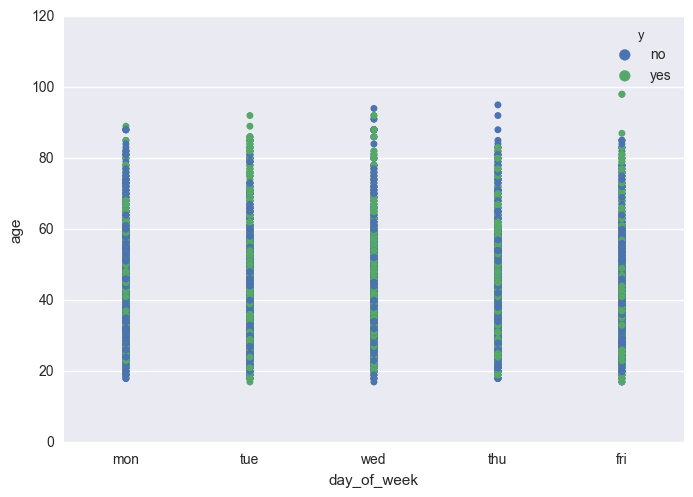

In [6]:
sns.stripplot(x="day_of_week", y="age", hue="y", data=bank_data)

There seems to be a lot of differences between gradations within categorical variables. This may be a good use case for an ensemble of decision trees. Let's test for outliers of 1D Series using subrange ratios and [Dixon's Q-test](http://195.134.76.37/applets/AppletQtest/Appl_Qtest2.html).

In [7]:
def q_test_for_smallest_point(dataset):
    q_ref = 0.29  # the reference Q value for a significance level of 95% and 30 data points
    q_stat = (dataset[1] - dataset[0])/(dataset[-1] - dataset[0])
    
    if q_stat > q_ref:
        print("Since our Q-statistic is {:f} and {:f} > {:f}, we have evidence that our " \
        "minimum point IS an outlier to the data.".format(q_stat, q_stat, q_ref))
    else:
        print("Since our Q-statistic is {:f} and {:f} < {:f}, we have evidence that our " \
        "minimum point is NOT an outlier to the data.".format(q_stat, q_stat, q_ref))


In [8]:
duration = bank_data[100:130]['duration'].values.tolist()
duration.sort()
q_test_for_smallest_point(duration)

Since our Q-statistic is 0.041063 and 0.041063 < 0.290000, we have evidence that our minimum point is NOT an outlier to the data.


In [9]:
campaign = bank_data[100:130]['campaign'].values.tolist()
campaign.sort()
q_test_for_smallest_point(campaign)

Since our Q-statistic is 0.000000 and 0.000000 < 0.290000, we have evidence that our minimum point is NOT an outlier to the data.


[Additional Outlier Tests](http://colingorrie.github.io/outlier-detection.html)

## Tidying the Data

- Each variable is associated with one column
- Each observation is associated with one row

In [10]:
bank_data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

As noted before, the numerical is in the right int / float format, however, there is potentially a wealth of information hidden in the categorical data and text responses.

### Attribute Information for Reference

#### Bank client data

1. age (numeric)

2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5. default: has credit in default? (categorical: 'no','yes','unknown')

6. housing: has housing loan? (categorical: 'no','yes','unknown')

7. loan: has personal loan? (categorical: 'no','yes','unknown')

#### Related with the last contact of the current campaign

8. contact: contact communication type (categorical: 'cellular','telephone') 
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). 

*Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.*

#### Other attributes

12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### Social and economic context attributes

16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric) 
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

#### Output variable (desired target):

21. y - has the client subscribed a term deposit? (binary: 'yes','no')

The data is well cleaned so not much is needed in this step.

## Exploratory Analysis

In [11]:
# Quick look at the target variable
print("Target variable 'y' is yes or no -> classification problem")
print("Number of yes : " + str(bank_data[bank_data.y == "yes"].shape[0]))
print("Number of no : " + str(bank_data[bank_data.y == "no"].shape[0]))

Target variable 'y' is yes or no -> classification problem
Number of yes : 4640
Number of no : 36548


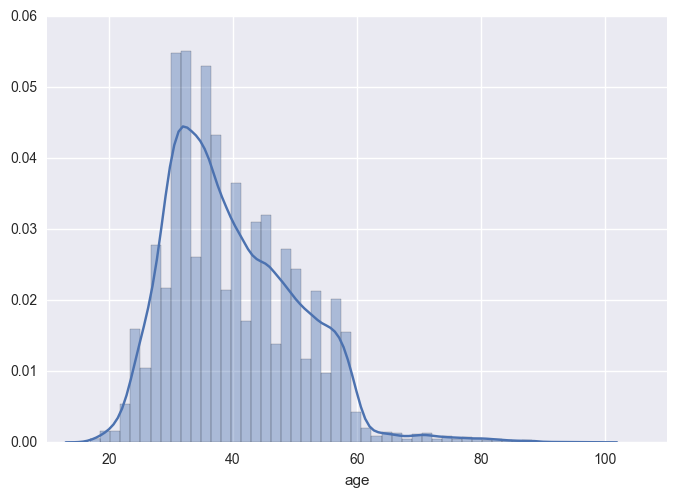

In [12]:
# Age
sns.distplot(bank_data['age'])

In [13]:
# Jobs
print(bank_data.job.value_counts())

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64


In [14]:
# Martial status
print(bank_data.marital.value_counts())

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64


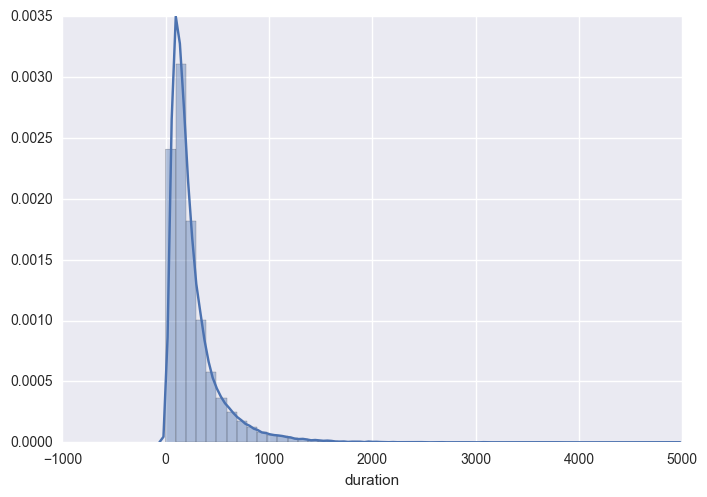

In [15]:
# Call duration
sns.distplot(bank_data['duration'])

1     17642
2     10570
3      5341
4      2651
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
15       51
16       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
25        8
26        8
28        8
30        7
31        7
35        5
33        4
32        4
34        3
40        2
42        2
43        2
37        1
39        1
41        1
56        1
Name: campaign, dtype: int64


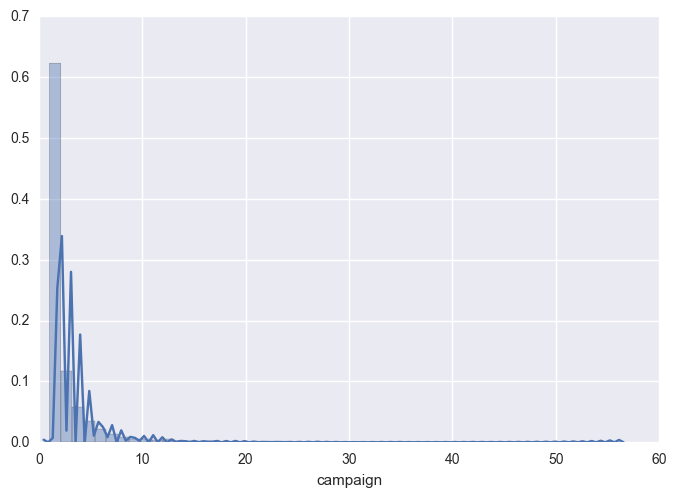

In [16]:
# Campaign
print(bank_data['campaign'].value_counts())
sns.distplot(bank_data['campaign'])

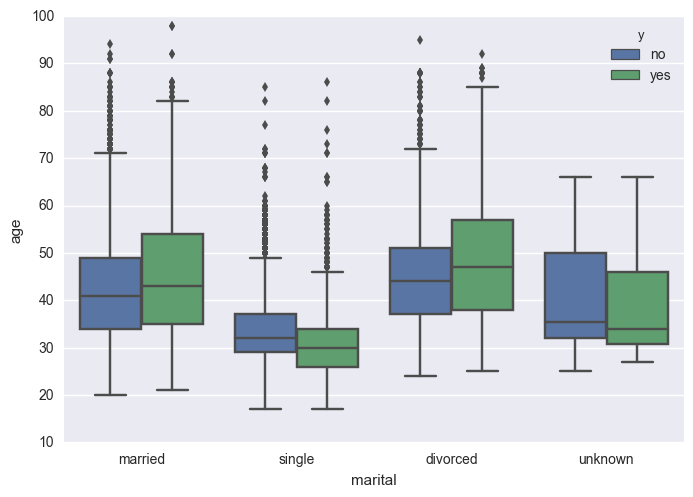

In [17]:
sns.boxplot(x="marital", y="age", hue="y", data=bank_data)

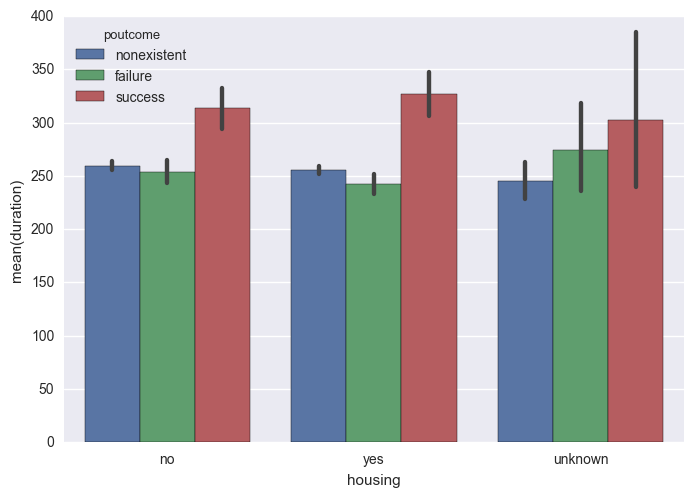

In [18]:
sns.barplot(x="housing", y="duration", hue="poutcome", data=bank_data)

## Preprocessing

In [19]:
import numpy as np

# Change yes/no to binary
bank_data = bank_data.replace(['yes', 'no'], [1, 0])

# Move y to front for readability
cols = bank_data.columns.tolist()
cols = cols[-1:] + cols[:-1]
bank_data = bank_data[cols]

# Replace 'unknown' with NAN and drop them
# I could potentially use an imputation strategy...
bank_data.replace(['unknown'], [np.nan], inplace=True)
bank_data = bank_data.dropna()

# Remove due to look-ahead bias
for i in ['duration', 'campaign', 'pdays', 'previous', 'poutcome']:
    del bank_data[i]

# Get dummy variables for categorical features
bank_data = pd.get_dummies(bank_data, columns=['month', 'day_of_week', 'job', 'marital', 'education', 'contact'])

# Remove "." from titles
bank_data.columns = ['y', 'age', 'default', 'housing', 'loan', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'job_admin_', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'marital_divorced', 'marital_married',
       'marital_single', 'education_basic_4y', 'education_basic_6y',
       'education_basic_9y', 'education_high_school', 'education_illiterate',
       'education_professional_course', 'education_university_degree',
       'contact_cellular', 'contact_telephone']

In [38]:
import pickle

# pickle.dump(bank_data, open('data/bank_data.pkl', 'wb'))
bank_data = pickle.load(open('data/bank_data.pkl', 'rb'))

In [39]:
from sklearn.model_selection import train_test_split

X, y = bank_data.iloc[:, 1:].values, bank_data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [40]:
# Bringing features for scale
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

 1) age                            0.237167
 2) euribor3m                      0.152937
 3) nr_employed                    0.061346
 4) housing                        0.054013
 5) emp_var_rate                   0.032238
 6) cons_conf_idx                  0.031543
 7) loan                           0.031412
 8) cons_price_idx                 0.027465
 9) job_admin_                     0.020216
10) marital_married                0.018625
11) education_university_degree    0.018612
12) education_high_school          0.018610
13) day_of_week_mon                0.016628
14) marital_single                 0.016614
15) day_of_week_thu                0.016300
16) day_of_week_wed                0.016224
17) day_of_week_tue                0.016173
18) day_of_week_fri                0.015188
19) job_technician                 0.015093
20) education_professional_course  0.014027
21) education_basic_9y             0.012051
22) marital_divorced               0.011817
23) job_blue-collar             

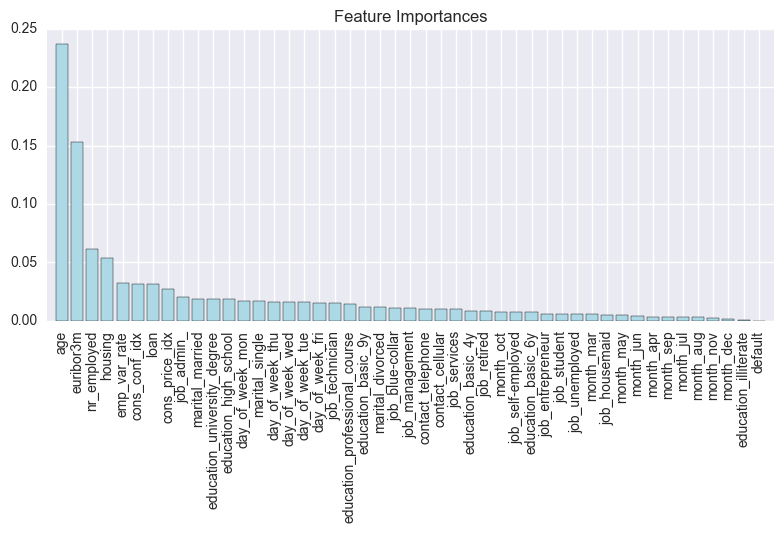

In [41]:
# Feature importance with Random Forests
from sklearn.ensemble import RandomForestClassifier

feat_labels = bank_data.columns[1:]

forest = RandomForestClassifier(n_estimators=1000,
                                random_state=0,
                                n_jobs=-1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
# plt.savefig('./images/random_forest.png', dpi=300)
plt.show()

## Dimensionality Reduction

In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([ 0.0958884 ,  0.05656313,  0.05144274,  0.04424959,  0.03938259])

In [43]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

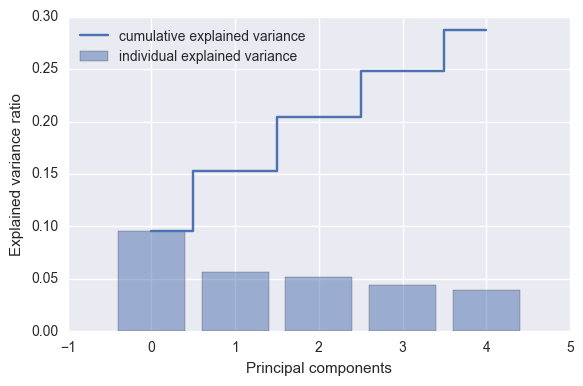

In [44]:
plt.figure(figsize=(6, 4))
plt.bar(range(5), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(5), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

PCA is not able to explain much variance. Rather not use principal components in the pipeline and stick to the regular variables. Other supervised or non-linear dimensionality reduction techniques could prove useful to explore.

## Model Evaluation and Hyperparameter Tuning

In [105]:
# Baseline model
most_common = bank_data.y.mode()
count = pd.Series(y_test).value_counts()
baseline = count[0] / len(y_test)
print('Baseline accuracy: %.3f' % (baseline))

Baseline accuracy: 0.876


In [91]:
# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forests": RandomForestClassifier(),
    "k-Nearest Neighbors": KNeighborsClassifier()
}

results = []
names = []

for k, v in models.items():
    cv_scores = cross_val_score(estimator=v,
                       X=X_train_std,
                       y=y_train,
                       cv=10,
                       n_jobs=1)
    
    results.append(cv_scores)
    names.append(k)

    print(k)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))
    print('----------------')

Random Forests
CV accuracy: 0.867 +/- 0.005
----------------
k-Nearest Neighbors
CV accuracy: 0.869 +/- 0.003
----------------
Decision Tree
CV accuracy: 0.828 +/- 0.009
----------------
Logistic Regression
CV accuracy: 0.878 +/- 0.004
----------------


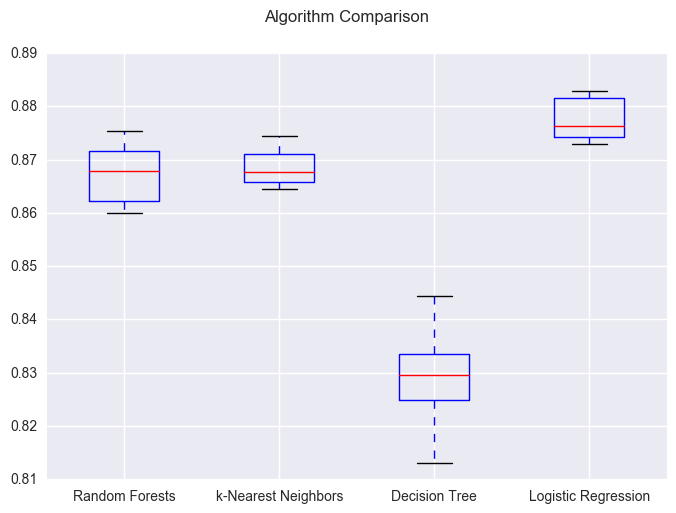

In [92]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

I'm going to focus in on tuning the Logistic Regression classifier.

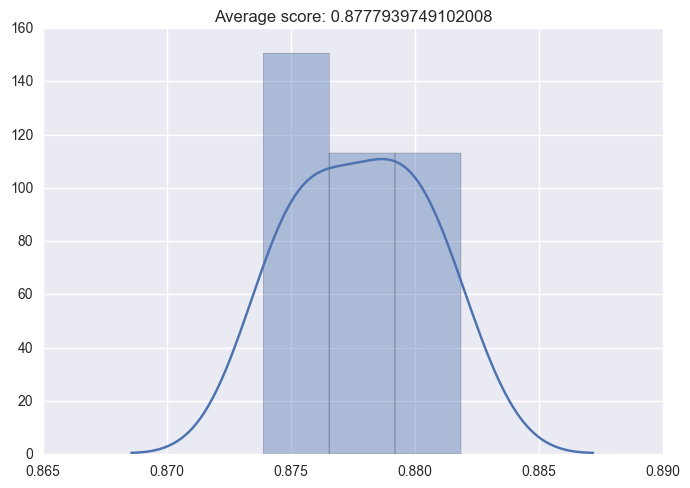

In [33]:
# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance

cv_scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=10)
sns.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

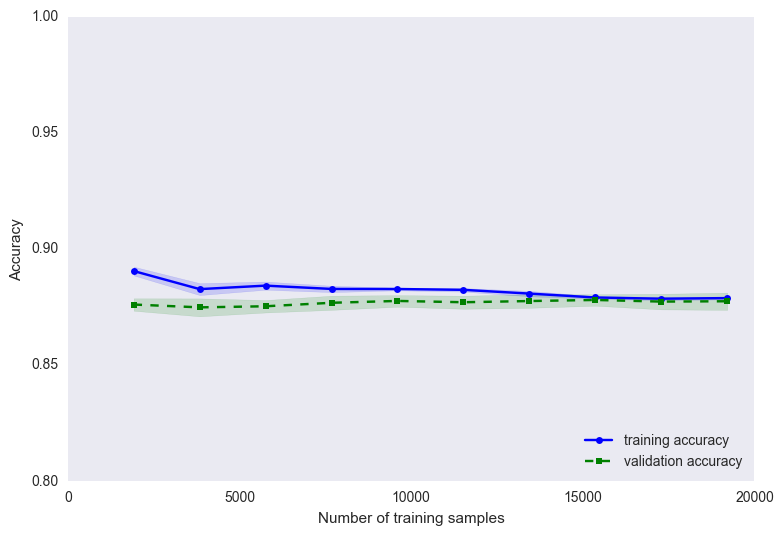

In [49]:
# Use the learning curve to check for overfitting
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', random_state=0))])

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,
                                                        n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./images/learning_curve.png', dpi=300)
plt.show()

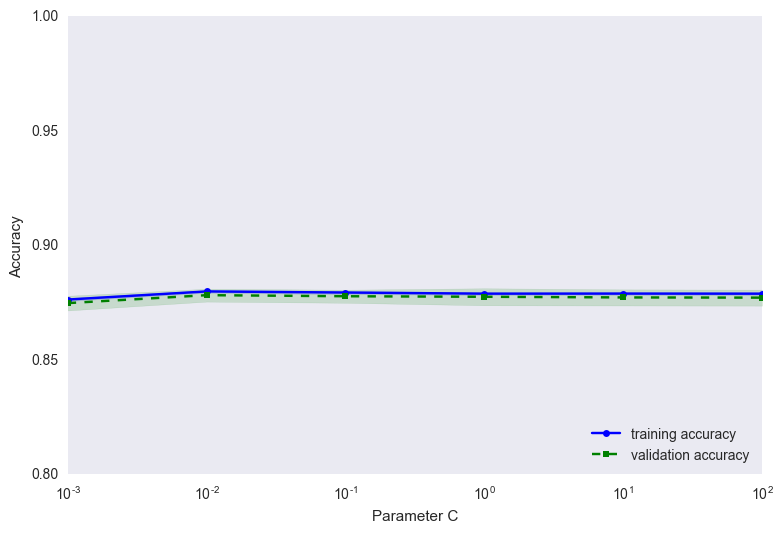

In [50]:
# Examine hyperparameters
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='clf__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.savefig('./images/validation_curve.png', dpi=300)
plt.show()

In [54]:
# Grid search with a stratified KFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold

parameter_grid = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

cross_validation = StratifiedKFold(n_splits=10)

gs = GridSearchCV(pipe_lr,
                  param_grid=parameter_grid,
                  cv=cross_validation)

gs.fit(X_train, y_train)
print('Best score: {}'.format(gs.best_score_))
print('Best parameters: {}'.format(gs.best_params_))

Best score: 0.8782156412539244
Best parameters: {'clf__C': 0.01}


In [56]:
clf = gs.best_estimator_
clf.fit(X_train_std, y_train)
print('Test accuracy: %.3f' % clf.score(X_test_std, y_test))

Test accuracy: 0.879


In [57]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

gs.fit(X_train_std, y_train)
y_pred = gs.predict(X_test_std)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[7807  204]
 [ 903  233]]


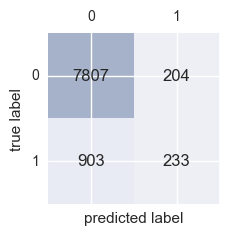

In [58]:
# Pretty confusion matrix
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.savefig('./images/confusion_matrix.png', dpi=300)
plt.show()

In [59]:
# Precision, recall and F1
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.533
Recall: 0.205
F1: 0.296


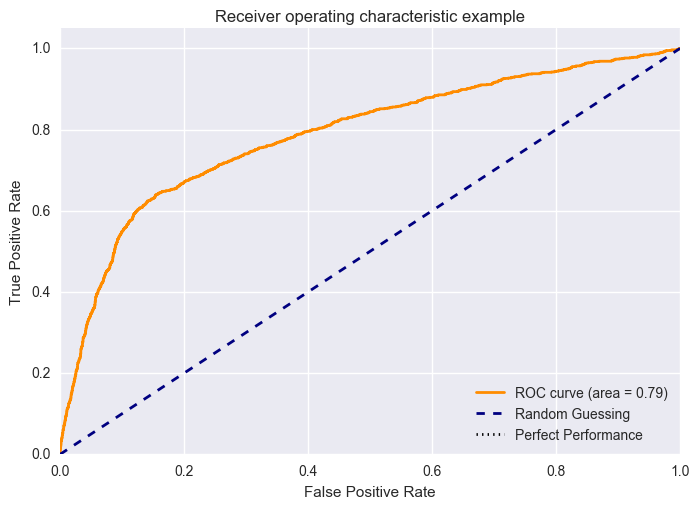

In [69]:
# Plot ROC curve
from sklearn.metrics import roc_curve, auc

y_score = LogisticRegression().fit(X_train_std, y_train).decision_function(X_test_std)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random Guessing')
plt.plot([1, 1], [1, 1], color='black', lw=lw, linestyle=':', label='Perfect Performance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [75]:
# AUC vs. Accuracy
from sklearn.metrics import roc_auc_score, accuracy_score

y_labels = LogisticRegression().fit(X_train_std, y_train).predict(X_test_std)
y_probas = LogisticRegression().fit(X_train_std, y_train).predict_proba(X_test_std)[:, 1]

print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_probas))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_labels))

ROC AUC: 0.788
Accuracy: 0.878


I will definitely need to do more feature engineering or use crazy optimized algorithms like XGBoost or Deep Learning in order to get >90% Accuracy. The pipeline is flexible enough to handle new data from additional campaigns when that data set is ready. The out-of-sample testing data accuracy score was extremely close to the cross-validation accuracy scores. Our model does not overfit and generalizes well for unseen data.

## Written Analysis

In [ ]:
## See Repository README

## Additional Analysis

- Precision-Recall Curve
- Feature Engineering
- Voting Ensembles
- XGBoost
- Deep Learning